# Vignette 1: Introduction to NetworkCommons

Welcome to `NetworkCommons`! In this initial vignette, we will go through the basics of the package, using one method to create and visualise a contextualised subnetwork.

In this vignette, we will use a single contrast (Afatinib-treated vs DMSO-treated ASPC cells) from the [PANACEA](../datasets.html#panacea) dataset to contextualise a signalling network from [OmniPath](../datasets.html#omnipath). For this, we will:

1. Download the data from the server. In this case, the data has already been processed, using filtering + DESeq2 for differential expression analysis, coupled to TF activity estimation using Decoupler-py and CollecTRI

3. Contextualise the network signalling network, using EGFR as perturbation (inhibited by Afatinib) and TFs as measurements, using one contextualization method as an example.

4. Visualise the solution network.

First, we need to import the packages that we're going to use in this notebook

In [1]:
import networkcommons as nc
import pandas as pd

## 1. Loading preprocessed transcriptomics data

We can see the available datasets, along with some information about them, using the ``nc.data.omics.datasets`` util function. For more information about the data itself, check the [Datasets details page](../datasets.html).

In [2]:
nc.data.omics.datasets()

,name,description,publication_link,detailed_description
decryptm,DecryptM,Drug perturbation proteomics and phosphoproteomics data,https://doi.org/10.1126/science.ade3925,"This dataset contains the profiling of 31 cancer drugs in 13 human cancer cell line models resulted in 1.8 million dose-response curves, including 47,502 regulated phosphopeptides, 7316 ubiquitinylated peptides, and 546 regulated acetylated peptides."
panacea,Panacea,Pancancer Analysis of Chemical Entity Activity RNA-Seq data,https://doi.org/10.1016/j.xcrm.2021.100492,"PANACEA contains dose-response and perturbational profiles for 32 kinase inhibitors in 11 cancer cell lines, in addition to a DMSO control. Originally, this resource served as the basis for a DREAM Challenge assessing the accuracy and sensitivity of computational algorithms for de novo drug polypharmacology predictions."
CPTAC,CPTAC,Clinical Proteomic Tumor Analysis Consortium data,https://doi.org/10.1158/2159-8290.CD-13-0219,This dataset contains data from the Clinical Proteomic Tumor Analysis Consortium. It includes various cancer types and proteomic data.
NCI60,NCI60,NCI-60 cell line data,https://doi.org/10.1038/nrc1951,"This dataset contains data from the NCI-60 cell line panel. It includes three files: TF activities from transcriptomics data, metabolite abundances and gene reads."


For this vignette, we will use the PANACEA dataset:

> Eugene F. Douglass et al., A community challenge for a pancancer drug mechanism of action inference from perturbational profile data. *Cell Reports Medicine (2022)*. https://doi.org/10.1016/j.xcrm.2021.100492.

PANACEA is a collection of perturbational transcriptomics profiles of 32 drugs and 11 cell lines.
Users can retrieve a raw count matrix and metadata associated, but they can also get differential expression estimates directly from the server. For the sake of simplicity, we will do the latter.
In this specific processing, we used the filtering strategy from *filterbyExpr* from the edgeR package, coupled with differential expression analysis with DESeq2. For the TF enrichment, we used CollecTRI as GRN and univariate linear model (via decoupler-py) as method.

In this vignette we will focus on the signalling network from network, thus our measurement layer will be at the TF level.

`Networkcommons` provides a function to covert dataframes to doctionaries containing signs, which is the input that most methods require.

In [3]:
dc_estimates = nc.data.omics.panacea_tables(cell_line='ASPC', drug='AFATINIB', type='TF_scores')
dc_estimates.set_index('items', inplace=True)
measurements = nc.utils.targetlayer_formatter(dc_estimates, act_col='act')

Now, we have our set of TF measurements, that encodes the effects of the drug-induced perturbation.

Afatinib targets EGFR by inhibition, so we will create a source dictionary containing the origin of perturbation, EGFR, and the sign of the perturbation (negative, therefore -1).

In [4]:
source_df = pd.DataFrame({'source': ['EGFR'], 
                          'sign': [-1]}, columns=['source', 'sign'])
source_df.set_index('source', inplace=True)
sources = source_df['sign'].to_dict()

## 2. Network inference

The methods included in NetworkCommons require a prior knowledge network, which will be used to obtain a smaller network with only the nodes relevant to the problem selected by the user. 

NetworkCommons provides access to some prior knowledge resources, but users are also welcome to use their own prior knowledge instead. For this, NetworkCommons has several built-in functionalities to convert edge lists (`pd.DataFrame`) into Network objects.

For example, this pandas DataFrame:

In [4]:
edge_list = pd.DataFrame({'source': ['A', 'B', 'C'], 'target': ['B', 'C', 'D'], 'sign': [1, -1, 1]})
print(edge_list)

  source target  sign
0      A      B     1
1      B      C    -1
2      C      D     1


can be easily converted into a Network object:

In [12]:
pk_network = nc.utils.network_from_df(edge_list)
type(pk_network)

networkx.classes.digraph.DiGraph

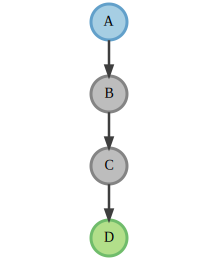

In [13]:
visualizer = nc.visual.NetworkXVisualizer(pk_network)
visualizer.visualize_network({'A':-1}, {'D':1})

Returning to our initial problem, we have obtained our set of TF measurements, which we will use as footprints of the perturbation induced by Afatinib. Here (and in most of the following vignettes), we will leverage the prior knowledge network (PKN) sourced from OmniPath, which contains a curated collection of signalling pathways and regulatory elements.  We will use these TF measurements to contextualise this general PKN.

In [5]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

Now, we are ready to contextualise our prior-knowledge network using the source and measurement layers to (hopefully) gain insights about the dysregulated elements in the network. As an initial example, we will only use one simple method.

The [shortest path approach](../methods.html#shortest-path) retrieves the shortest path between source and target nodes. In the case where there are many paths with the same length, all these paths will be retrieved.

In [6]:
shortest_path_network, shortest_paths_list = nc.methods.run_shortest_paths(graph, sources, measurements)

Now, we have our solution network! Let's see how it looks using a simple visualization option:

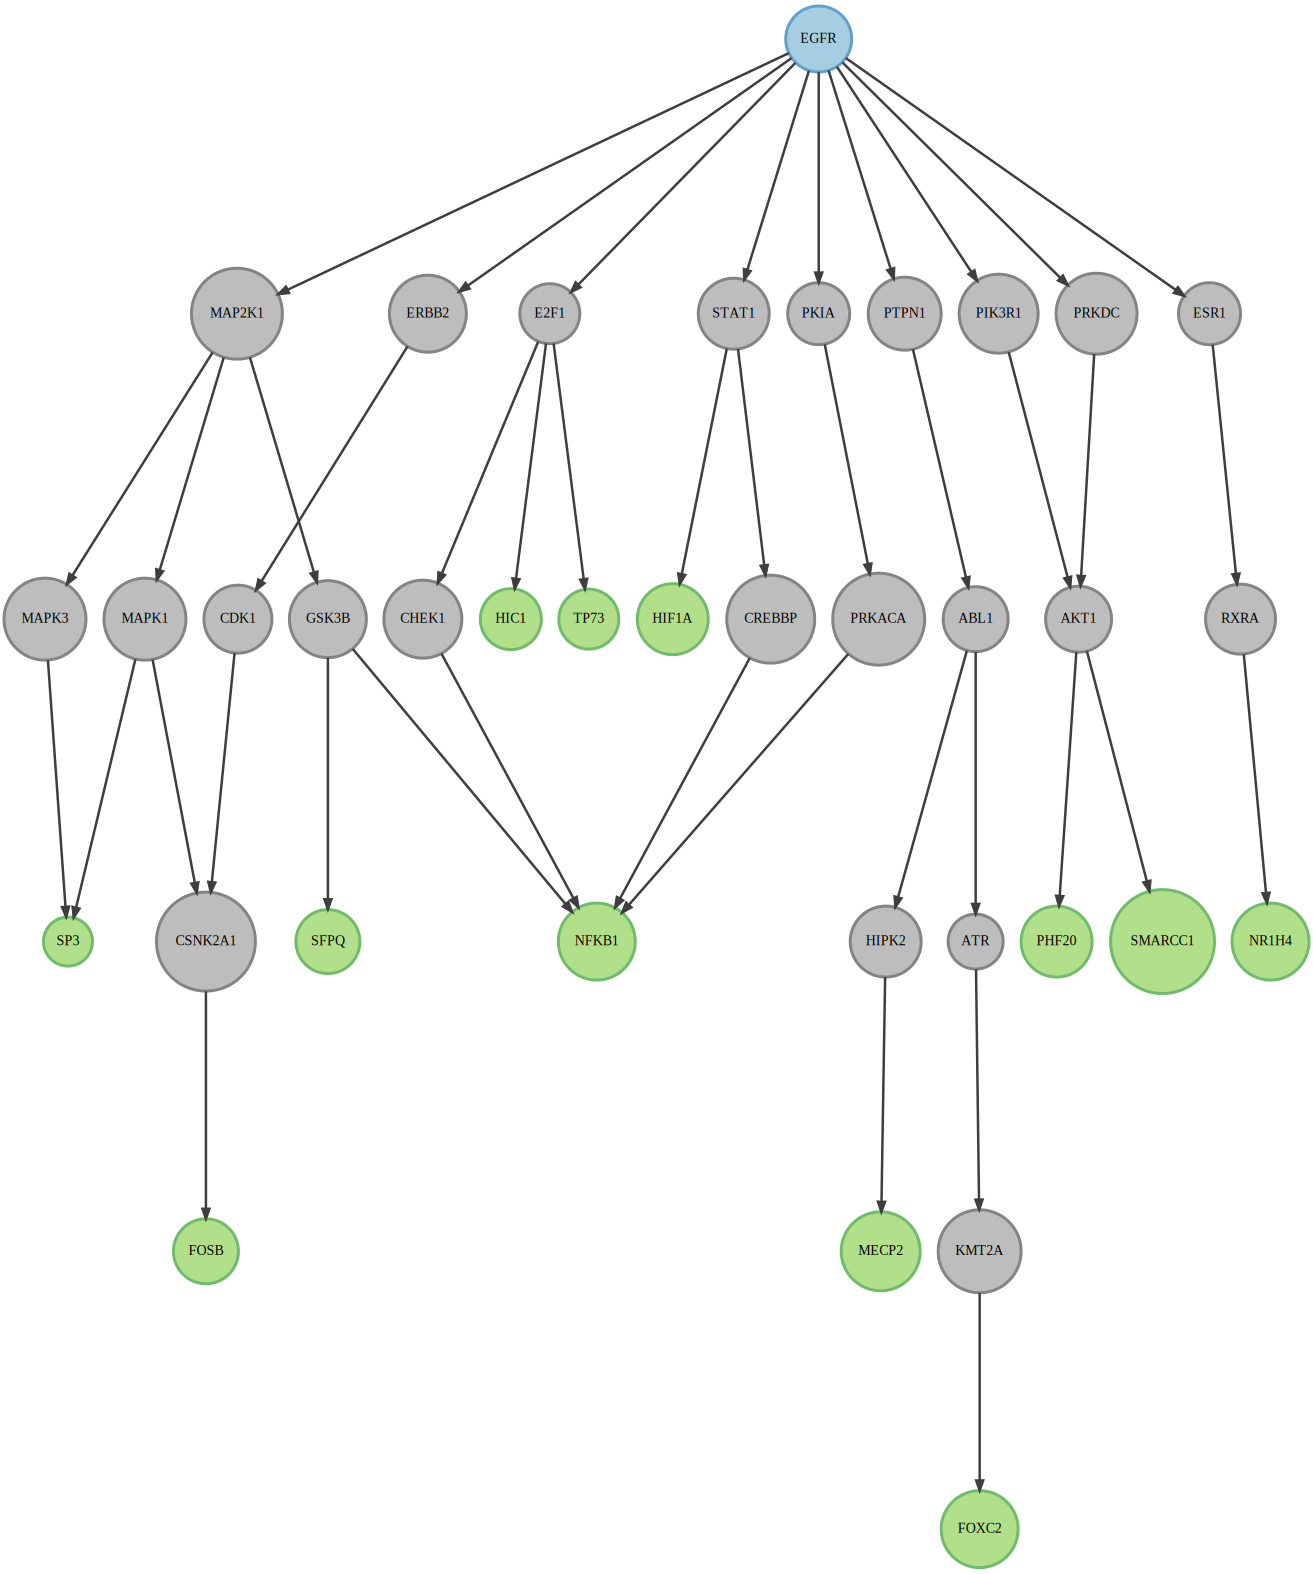

In [7]:
visualizer = nc.visual.NetworkXVisualizer(shortest_path_network)
visualizer.visualize_network(sources, measurements)

And that was it! In this vignette we learned how to format source and target layers, perform network inference using the shortest paths method, and to visualise the resulting solution network. If you want to deepen in the functionalities of `Networkcommons`, please check our other vignettes!